<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/denoiser_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Denoiser with Auto Encoder

## Import

In [170]:
import numpy as np
import random
import keras
from keras import models
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from skimage.util import random_noise

## Dataset

In [171]:
## MNIST - 60 000 img of hand writted digit

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Number :  5


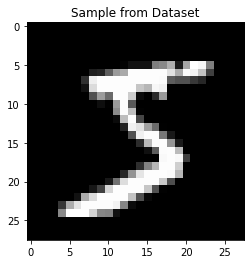

In [172]:
# Normalize

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
train_labels = to_categorical(train_labels)

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
test_labels = to_categorical(test_labels)

# Show a sample

print("Number : ", train_labels[0].argmax())
plt.title("Sample from Dataset")
plt.imshow(train_images[0].reshape(28, 28), cmap='gray')

Number :  5


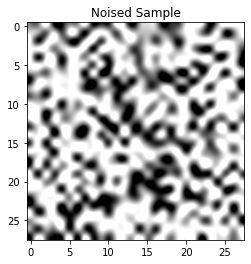

In [173]:
def add_noise(data):
  """Add noise to a given dataset"""

  new_data = np.copy(data)
  for i,image in enumerate(new_data):
      image=random_noise(image, mode='gaussian', mean=0, var=0.3)
      image=random_noise(image, mode='s&p',      amount=0.2, salt_vs_pepper=0.5)
      image=random_noise(image, mode='poisson') 
      image=random_noise(image, mode='speckle',  mean=0, var=0.1)
      new_data[i]=image

  return new_data


# Add noise on train and test set

noised_train_images = add_noise(train_images)
noised_test_images = add_noise(test_images)

# Show a noised sample

print("Number : ", train_labels[0].argmax())
plt.title("Noised Sample")
plt.imshow(noised_train_images[0].reshape(28, 28), cmap='binary', interpolation='lanczos')

## Model

In [174]:
# ENCODER

latent_dim = 10

inputs    = keras.Input(shape=(28, 28, 1))
x         = keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(16, activation="relu")(x)
z         = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")

In [175]:
# DECODER

inputs  = keras.Input(shape=(latent_dim,))
x       = keras.layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = keras.layers.Reshape((7, 7, 64))(x)
x       = keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")

In [176]:
# AUTO ENCODER

inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name="ae")

ae.summary()

Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 10)                69178     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         90177     
                                                                 
Total params: 159,355
Trainable params: 159,355
Non-trainable params: 0
_________________________________________________________________


## Training

In [178]:
epochs = 10
batch_size = 128

ae.compile(optimizer="adam", loss='binary_crossentropy', metrics=["acc"])

history = ae.fit(
    noised_train_images, 
    train_images, 
    epochs=epochs, 
    validation_data=(noised_test_images, test_images))

Epoch 1/10
1875/1875 [==============================] - 14s 6ms/step - loss: 0.2403 - acc: 0.7961 - val_loss: 0.2237 - val_acc: 0.7944
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2141 - acc: 0.7945 - val_loss: 0.2030 - val_acc: 0.7945
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2012 - acc: 0.7950 - val_loss: 0.1991 - val_acc: 0.7956
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1986 - acc: 0.7954 - val_loss: 0.1969 - val_acc: 0.7954
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1971 - acc: 0.7957 - val_loss: 0.1966 - val_acc: 0.7953
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1961 - acc: 0.7959 - val_loss: 0.1968 - val_acc: 0.7935
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1955 - acc: 0.7960 - val_loss: 0.1960 - val_acc: 0.7948
Epoch 8/10
1875/1875 [==============================] -

## Results

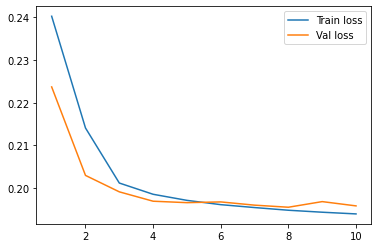

In [179]:
# LOG RESULTS
epochs_range = range(1, epochs + 1)
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(epochs_range, loss, label="Train loss")
plt.plot(epochs_range, val_loss, label="Val loss")

plt.legend()
plt.show()

## Prediction

In [184]:
preds = ae.predict(noised_test_images[0:1])

1/1 [==============================] - 0s 23ms/step


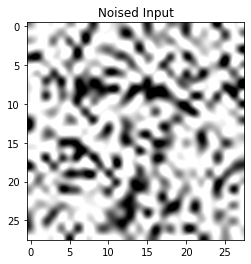

In [181]:
plt.title("Noised Input")
plt.imshow(noised_test_images[0].reshape(28, 28), cmap='binary', interpolation='lanczos')

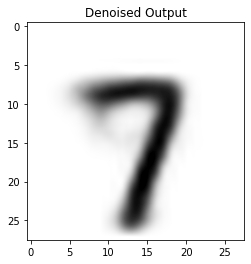

In [182]:
plt.title("Denoised Output")
plt.imshow(preds[0].reshape(28, 28), cmap='binary', interpolation='lanczos')

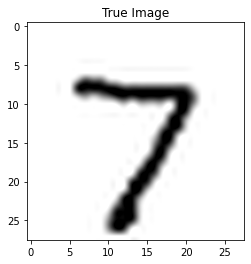

In [183]:
plt.title("True Image")
plt.imshow(test_images[0].reshape(28, 28), cmap='binary', interpolation='lanczos')